# Grover's Algorithm

In this section, we introduce Grover's algorithm and how it can be used to solve unstructured search problems. We then implement the quantum algorithm using Qiskit, and run on a simulator and device.


## Contents

1. [Introduction](#introduction)
2. [Example: 2 Qubits](#2qubits)    
   2.1 [Simulation](#2qubits-simulation)    
   2.2 [Device](#2qubits-device)    
3. [Example: 3 Qubits](#3qubits)     
   3.1 [Simulation](#3qubits-simulation)    
   3.2 [Device](#3qubits-device)    
4. [Problems](#problems)
5. [Solving Sudoku using Grover's Algorithm](#sudoku)
5. [References](#references)


## 1. Introduction <a id='introduction'></a>

You have likely heard that one of the many advantages a quantum computer has over a classical computer is its superior speed searching databases. Grover's algorithm demonstrates this capability. This algorithm can speed up an unstructured search problem quadratically, but its uses extend beyond that; it can serve as a general trick or subroutine to obtain quadratic run time improvements for a variety of other algorithms. This is called the amplitude amplification trick.

### Unstructured Search

Suppose you are given a large list of $N$ items. Among these items there is one item with a unique property that we wish to locate; we will call this one the winner $w$. Think of each item in the list as a box of a particular color. Say all items in the list are gray except the winner $w$, which is purple.

![image1](images/grover_list.png)

To find the purple box -- the *marked item* -- using classical computation, one would have to check on average $N/2$ of these boxes, and in the worst case, all $N$ of them. On a quantum computer, however, we can find the marked item in roughly $\sqrt{N}$ steps with Grover's amplitude amplification trick. A quadratic speedup is indeed a substantial time-saver for finding marked items in long lists. Additionally, the algorithm does not use the list's internal structure, which makes it *generic;* this is why it immediately provides a quadratic quantum speed-up for many classical problems.

### Creating an Oracle

For the examples in this textbook, our 'database' is comprised of all the possible computational basis states our qubits can be in. For example, if we have 3 qubits, our list is the states $|000\rangle, |001\rangle, \dots |111\rangle$ (i.e the states $|0\rangle \rightarrow |7\rangle$).

Grover’s algorithm solves oracles that add a negative phase to the solution states. I.e. for any state $|x\rangle$ in the computational basis:

$$
U_\omega|x\rangle = \bigg\{
\begin{aligned}
\phantom{-}|x\rangle \quad \text{if} \; x \neq \omega \\
-|x\rangle \quad \text{if} \; x = \omega \\
\end{aligned}
$$

This oracle will be a diagonal matrix, where the entry that correspond to the marked item will have a negative phase. For example, if we have three qubits and $\omega = \text{101}$, our oracle will have the matrix:

$$
U_\omega = 
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
\end{bmatrix}
\begin{aligned}
\\
\\
\\
\\
\\
\\
\leftarrow \omega = \text{101}\\
\\
\\
\\
\end{aligned}
$$


What makes Grover’s algorithm so powerful is how easy it is to convert a problem to an oracle of this form. There are many computational problems in which it’s difficult to _find_ a solution, but relatively easy to _verify_ a solution. For example, we can easily verify a solution to a [sudoku](https://en.wikipedia.org/wiki/Sudoku) by checking all the rules are satisfied. For these problems, we can create a function $f$ that takes a proposed solution $x$, and returns $f(x) = 0$ if $x$ is not a solution ($x \neq \omega$) and $f(x) = 1$ for a valid solution ($x = \omega$). Our oracle can then be described as:

$$
U_\omega|x\rangle = (-1)^{f(x)}|x\rangle
$$

and the oracle's matrix will be a diagonal matrix of the form:

$$
U_\omega = 
\begin{bmatrix}
(-1)^{f(0)} &   0         & \cdots &   0         \\
0           & (-1)^{f(1)} & \cdots &   0         \\
\vdots      &   0         & \ddots & \vdots      \\
0           &   0         & \cdots & (-1)^{f(2^n-1)} \\
\end{bmatrix}
$$

<details>
    <summary>Circuit Construction of a Grover Oracle (click to expand)</summary>
<p>
If we have our classical function $f(x)$, we can convert it to a reversible circuit of the form:
</p><p>
<img alt="A Classical Reversible Oracle" src="images/grover_boolean_oracle.svg">
</p><p>
If we initialise the 'output' qubit in the state $|{-}\rangle$, the phase kickback effect turns this into a Grover oracle (similar to the workings of the Deutsch-Jozsa oracle):
</p><p>  
<img alt="Grover Oracle Constructed from a Classical Reversible Oracle" src="images/grover_phase_oracle.svg">
</p><p>
We then ignore the auxiliary ($|{-}\rangle$) qubit.
</p>
</details>

For the next part of this chapter, we aim to teach the core concepts of the algorithm. We will create example oracles where we know $\omega$ beforehand, and not worry ourselves with whether these oracles are useful or not. At the end of the chapter, we will cover a short example where we create an oracle to solve a problem (sudoku).

### Amplitude Amplification

So how does the algorithm work? Before looking at the list of items, we have no idea where the marked item is. Therefore, any guess of its location is as good as any other, which can be expressed in terms of a
uniform superposition: $|s \rangle = \frac{1}{\sqrt{N}} \sum_{x = 0}^{N -1} | x
\rangle.$

If at this point we were to measure in the standard basis $\{ | x \rangle \}$, this superposition would collapse, according to the fifth quantum law, to any one of the basis states with the same probability of $\frac{1}{N} = \frac{1}{2^n}$. Our chances of guessing the right value $w$ is therefore $1$ in $2^n$, as could be expected. Hence, on average we would need to try about $N/2 = 2^{n-1}$ times to guess the correct item.

Enter the procedure called amplitude amplification, which is how a quantum computer significantly enhances this probability. This procedure stretches out (amplifies) the amplitude of the marked item, which shrinks the other items' amplitude, so that measuring the final state will return the right item with near-certainty. 

This algorithm has a nice geometrical interpretation in terms of two reflections, which generate a rotation in a two-dimensional plane. The only two special states we need to consider are the winner $| w \rangle$ and the uniform superposition $| s \rangle$. These two vectors span a two-dimensional plane in the vector space $\mathbb{C}^N.$ They are not quite perpendicular because $| w \rangle$ occurs in the superposition with amplitude $N^{-1/2}$ as well.
We can, however, introduce an additional state $|s'\rangle$ that is in the span of these two vectors, which is perpendicular to $| w \rangle$ and is obtained from $|s \rangle$ by removing $| w \rangle$ and
rescaling. 

**Step 1**: The amplitude amplification procedure starts out in the uniform superposition $| s \rangle$, which is easily constructed from $| s \rangle = H^{\otimes n} | 0 \rangle^n$.

![image2](images/grover_step1.jpg)


The left graphic corresponds to the two-dimensional plane spanned by perpendicular vectors $|w\rangle$ and $|s'\rangle$ which allows to express the initial state as $|s\rangle = \sin \theta | w \rangle + \cos \theta | s' \rangle,$ where $\theta = \arcsin \langle s | w \rangle = \arcsin \frac{1}{\sqrt{N}}$. The right graphic is a bar graph of the amplitudes of the state $| s \rangle$.

**Step 2**: We apply the oracle reflection $U_f$ to the state $|s\rangle$.

![image3](images/grover_step2.jpg)

Geometrically this corresponds to a reflection of the state $|s\rangle$ about $|s'\rangle$. This transformation means that the amplitude in front of the $|w\rangle$ state becomes negative, which in turn means that the average amplitude (indicated by a dashed line) has been lowered.

**Step 3**: We now apply an additional reflection ($U_s$) about the state $|s\rangle$: $U_s = 2|s\rangle\langle s| - I$ . This transformation maps the state to $U_s U_f| s \rangle$ and completes the transformation. 

![image4](images/grover_step3.jpg)

Two reflections always correspond to a rotation. The transformation $U_s U_f$ rotates the initial state $|s\rangle$ closer towards the winner $|w\rangle$. The action of the reflection $U_s$ in the amplitude bar diagram can be understood as a reflection about the average amplitude. Since the average amplitude has been lowered by the first reflection, this transformation boosts the negative amplitude of $|w\rangle$ to roughly three times its original value, while it decreases the other amplitudes. We then go to **step 2** to repeat the application. This procedure will be repeated several times to zero in on the winner. 

After $t$ steps we will be in the state $|\psi_t\rangle$ where: $| \psi_t \rangle = (U_s U_f)^t  | s \rangle.$

How many times do we need to apply the rotation? It turns out that roughly $\sqrt{N}$ rotations suffice. This becomes clear when looking at the amplitudes of the state $| \psi \rangle$. We can see that the amplitude of $| w \rangle$ grows linearly with the number of applications $\sim t N^{-1/2}$. However, since we are dealing with amplitudes and not probabilities, the vector space's dimension enters as a square root. Therefore it is the amplitude, and not just the probability, that is being amplified in this procedure.

In the case that there are multiple solutions, $M$, it can be shown that roughly $\sqrt{(N/M)}$ rotations will suffice.

![image5](images/grover_circuit_high_level.png)

## 2. Example: 2 Qubits <a id='2qubits'></a>

Let's first have a look at the case of Grover's algorithm for $N=4$ which is realized with 2 qubits. In this particular case, only <b>one rotation</b> is required to rotate the initial state $|s\rangle$ to the winner $|w\rangle$[3]:

Following  the above introduction, in the case $N=4$ we have 

$$\theta = \arcsin \frac{1}{2} = \frac{\pi}{6}.$$

After $t$ steps, we have $$(U_s U_\omega)^t  | s \rangle = \sin \theta_t | \omega \rangle + \cos \theta_t | s' \rangle ,$$where $$\theta_t = (2t+1)\theta.$$

In order to obtain $| \omega \rangle$ we need $\theta_t = \frac{\pi}{2}$, which with $\theta=\frac{\pi}{6}$ inserted above results to $t=1$. This implies that after $t=1$ rotation the searched element is found.


We will now follow through an example using a specific oracle.

#### Oracle for $\lvert \omega \rangle = \lvert 11 \rangle$
Let's look at the case $\lvert w \rangle = \lvert 11 \rangle$. The oracle $U_\omega$ in this case acts as follows: 

$$U_\omega | s \rangle = U_\omega \frac{1}{2}\left( |00\rangle + |01\rangle + |10\rangle + |11\rangle \right) = \frac{1}{2}\left( |00\rangle + |01\rangle + |10\rangle - |11\rangle \right).$$

or:

$$
U_\omega = 
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & -1 \\
\end{bmatrix}
$$

which you may recognise as the controlled-Z gate. Thus, for this example, our oracle is simply the controlled-Z gate:

c-Z = Controlled Z-gate

![image6](images/grover_circuit_2qbuits_oracle_11.svg)

#### Reflection $U_s$
In order to complete the circuit we need to implement the additional reflection $U_s = 2|s\rangle\langle s| - I$. Since this is a reflection about $|s\rangle$, we want to add a negative phase to every state orthogonal to $|s\rangle$. 

One way we can do this is to use the operation that transforms the state $|s\rangle \rightarrow |0\rangle$, which we already know is the Hadamard gate applied to each qubit:

$$H^{\otimes n}|s\rangle = |0\rangle$$

Then we apply a circuit that adds a negative phase to the states orthogonal to $|0\rangle$:

$$U_0 \frac{1}{2}\left( \lvert 00 \rangle + \lvert 01 \rangle + \lvert 10 \rangle + \lvert 11 \rangle \right) = \frac{1}{2}\left( \lvert 00 \rangle - \lvert 01 \rangle - \lvert 10 \rangle - \lvert 11 \rangle \right)$$

i.e. the signs of each state are flipped except for $\lvert 00 \rangle$. As can easily be verified, one way of implementing $U_0$ is the following circuit:

![Circuit for reflection around |0>](images/grover_circuit_2qbuits_reflection_0.svg)

Finally, we do the operation that transforms the state $|0\rangle \rightarrow |s\rangle$ (the H-gate again):

$$H^{\otimes n}U_0 H^{\otimes n} = U_s$$

The complete circuit for $U_s$ looks like this:

![Circuit for reflection around |s>](images/grover_circuit_2qbuits_reflection.svg)


#### Full Circuit for $\lvert w \rangle = |11\rangle$
Since in the particular case of $N=4$ only one rotation is required we can combine the above components to build the full circuit for Grover's algorithm for the case $\lvert w \rangle = |11\rangle$:

![image10](images/grover_circuit_2qubits_full_11.svg)

### 2.1 Qiskit Implementation

We now implement Grover's algorithm for the above case of 2 qubits for $\lvert w \rangle = |11\rangle$.

In [1]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import Options, Session, SamplerV2 as Sampler
backend_sim = AerSimulator()
simulator = AerSimulator()

#Import an estimator, this time from qiskit (we import from Runtime for real hardware)
from qiskit.primitives import BackendSampler
sampler = BackendSampler(backend = backend_sim)
import numpy as np
from qiskit.visualization import plot_bloch_vector, plot_histogram,plot_bloch_multivector
import matplotlib.pyplot as plt

from qiskit.circuit import QuantumRegister, ClassicalRegister, QuantumCircuit, Parameter, Gate
from qiskit import QuantumCircuit, transpile
from qiskit.result import marginal_counts
from qiskit.circuit.library import QFT

/var/folders/wf/3snlfs053z5cdskpx0b4lfpm0000gn/T/ipykernel_6914/1627933727.py:8: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler = BackendSampler(backend = backend_sim)


We start by preparing a quantum circuit with two qubits:

In [2]:
n = 2
grover_circuit = QuantumCircuit(n)

Then we simply need to write out the commands for the circuit depicted above. First, we need to initialize the state $|s\rangle$. Let's create a general function (for any number of qubits) so we can use it again later:

In [3]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

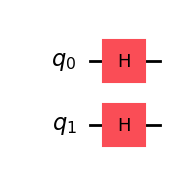

In [4]:
grover_circuit = initialize_s(grover_circuit, [0,1])
grover_circuit.draw('mpl')

Apply the Oracle for $|w\rangle = |11\rangle$. This oracle is specific to 2 qubits:

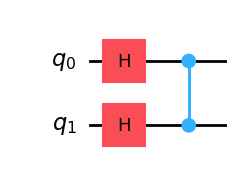

In [5]:
grover_circuit.cz(0,1) # Oracle
grover_circuit.draw('mpl')

<span id="general_diffuser"></span>We now want to apply the diffuser ($U_s$). As with the circuit that initializes $|s\rangle$, we'll create a general diffuser (for any number of qubits) so we can use it later in other problems. 

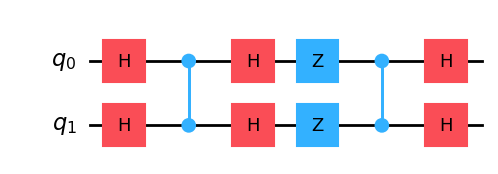

In [6]:
# Diffusion operator (U_s)
grover_circuit.h([0,1])
grover_circuit.z([0,1])
grover_circuit.cz(0,1)
grover_circuit.h([0,1])
grover_circuit.draw('mpl')

This is our finished circuit.

### 2.1.1 Experiment with Simulators <a id='2qubits-simulation'></a>

Let's run the circuit in simulation. First, we can verify that we have the correct statevector:

Statevector([1.96261557e-16-3.69778549e-32j,
             2.22044605e-16+1.22464680e-16j,
             1.96261557e-16+1.22464680e-16j,
             1.00000000e+00-2.44929360e-16j],
            dims=(2, 2))


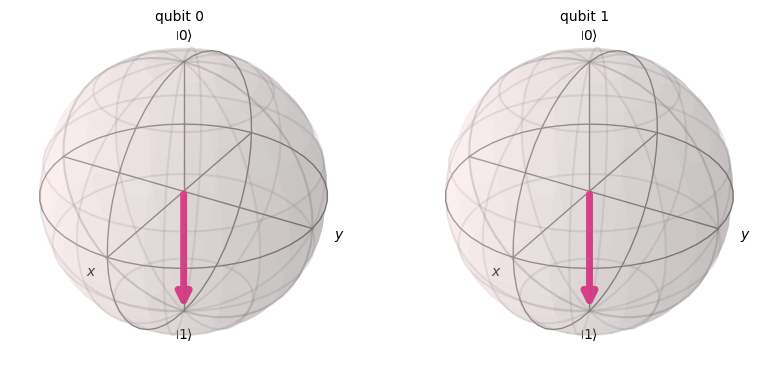

In [7]:
sim = AerSimulator()
# we need to make a copy of the circuit with the 'save_statevector'
# instruction to run on the Aer simulator
grover_circuit_sim = grover_circuit.copy()
grover_circuit_sim.save_statevector()
result = sim.run(grover_circuit_sim).result()
statevec = result.get_statevector()
print(statevec)
plot_bloch_multivector(statevec)

As expected, the amplitude of every state that is not $|11\rangle$ is 0, this means we have a 100% chance of measuring $|11\rangle$:

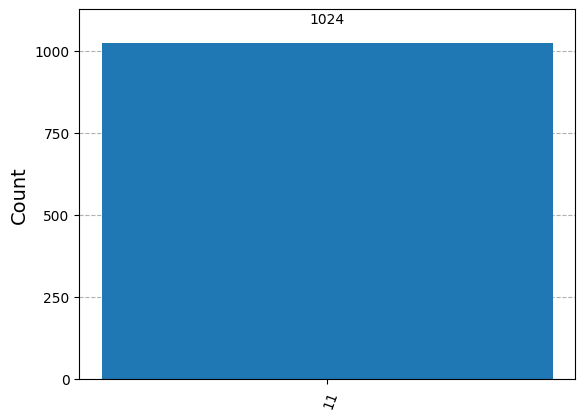

In [8]:
grover_circuit.measure_all()

result = sim.run(grover_circuit).result()
counts = result.get_counts()
plot_histogram(counts)

### 2.1.2 Experiment with Real Devices <a id='2qubits-device'></a>

We can run the circuit a real device as below.

In [9]:
# transpiling the circuits
from qiskit_ibm_runtime import QiskitRuntimeService
# Let s find the least busy backend
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy()
print(backend.name)
sampler = Sampler(mode=backend)
sampler.options.default_shots = 100

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm = generate_preset_pass_manager(optimization_level=3, backend=backend) 


ibm_brisbane


In [13]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
transpiled_grover_circuit = pm.run(grover_circuit)
job = sampler.run([transpiled_grover_circuit])


In [12]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)

AttributeError: 'PrimitiveResult' object has no attribute 'get_counts'

We confirm that in the majority of the cases the state $|11\rangle$ is measured. The other results are due to errors in the quantum computation. 

## 3. Example: 3 Qubits <a id='3qubits'></a>

We now go through the example of Grover's algorithm for 3 qubits with two marked states $\lvert101\rangle$ and $\lvert110\rangle$, following the implementation found in Reference [2]. The quantum circuit to solve the problem using a phase oracle is:

![image11](images/grover_circuit_3qubits.png)

<ol>
<li> 
  Apply Hadamard gates to $3$ qubits initialized to $\lvert000\rangle$ to create a uniform superposition:
  $$\lvert \psi_1 \rangle = \frac{1}{\sqrt{8}} \left( 
    \lvert000\rangle + \lvert001\rangle + \lvert010\rangle + \lvert011\rangle + 
    \lvert100\rangle + \lvert101\rangle + \lvert110\rangle + \lvert111\rangle \right) $$
</li>

<li>
  Mark states $\lvert101\rangle$ and $\lvert110\rangle$ using a phase oracle:
  $$\lvert \psi_2 \rangle = \frac{1}{\sqrt{8}} \left( 
    \lvert000\rangle + \lvert001\rangle + \lvert010\rangle + \lvert011\rangle + 
    \lvert100\rangle - \lvert101\rangle - \lvert110\rangle + \lvert111\rangle \right) $$
</li>

<li>
  Perform the reflection around the average amplitude:
    
  <ol>
   <li> Apply Hadamard gates to the qubits
      $$\lvert \psi_{3a} \rangle = \frac{1}{2} \left( 
        \lvert000\rangle +\lvert011\rangle +\lvert100\rangle -\lvert111\rangle \right) $$
   </li>
    
   <li> Apply X gates to the qubits
      $$\lvert \psi_{3b} \rangle = \frac{1}{2} \left( 
        -\lvert000\rangle +\lvert011\rangle +\lvert100\rangle +\lvert111\rangle \right) $$
   </li>

   <li> Apply a doubly controlled Z gate between the 1, 2 (controls) and 3 (target) qubits
      $$\lvert \psi_{3c} \rangle = \frac{1}{2} \left( 
        -\lvert000\rangle +\lvert011\rangle +\lvert100\rangle -\lvert111\rangle \right) $$
   </li>
   <li> Apply X gates to the qubits
      $$\lvert \psi_{3d} \rangle = \frac{1}{2} \left( 
        -\lvert000\rangle +\lvert011\rangle +\lvert100\rangle -\lvert111\rangle \right) $$
   </li>
   <li> Apply Hadamard gates to the qubits
      $$\lvert \psi_{3e} \rangle = \frac{1}{\sqrt{2}} \left( 
        -\lvert101\rangle -\lvert110\rangle \right) $$
   </li>
  </ol>
</li>

<li>
  Measure the $3$ qubits to retrieve states $\lvert101\rangle$ and $\lvert110\rangle$
</li>
</ol>

Note that since there are 2 solutions and 8 possibilities, we will only need to run one iteration (steps 2 & 3).

### 3.1 Qiskit Implementation <a id='3qubit-implementation'></a>

We now implement Grover's algorithm for the above [example](#3qubits) for $3$-qubits and searching for two marked states $\lvert101\rangle$ and $\lvert110\rangle$. **Note:** Remember that Qiskit orders it's qubits the opposite way round to this resource, so the circuit drawn will appear flipped about the horizontal.

We create a phase oracle that will mark states $\lvert101\rangle$ and $\lvert110\rangle$ as the results (step 1).

In [14]:
qc = QuantumCircuit(3)
qc.cz(0, 2)
qc.cz(1, 2)
oracle_ex3 = qc.to_gate()
oracle_ex3.name = "U$_\omega$"

<>:5: SyntaxWarning: invalid escape sequence '\o'
<>:5: SyntaxWarning: invalid escape sequence '\o'
/var/folders/wf/3snlfs053z5cdskpx0b4lfpm0000gn/T/ipykernel_6914/3153141584.py:5: SyntaxWarning: invalid escape sequence '\o'
  oracle_ex3.name = "U$_\omega$"


In the last section, we used a diffuser specific to 2 qubits, in the cell below we will create a general diffuser for any number of qubits.

<details>
<summary> Details: Creating a General Diffuser (click to expand)</summary>
    
Remember that we can create $U_s$ from $U_0$:

$$ U_s = H^{\otimes n} U_0 H^{\otimes n} $$

And a multi-controlled-Z gate ($MCZ$) inverts the phase of the state $|11\dots 1\rangle$:

$$
MCZ = 
\begin{bmatrix}
 1 & 0 & 0 & \cdots & 0 \\
 0 & 1 & 0 & \cdots & 0 \\
 \vdots & \vdots & \vdots & \ddots & \vdots \\
 0 & 0 & 0 & \cdots & -1 \\
\end{bmatrix}
\begin{aligned}
\\
\\
\\
\leftarrow \text{Add negative phase to} \; |11\dots 1\rangle\\
\end{aligned}
$$

Applying an X-gate to each qubit performs the transformation:

$$
\begin{aligned}
|00\dots 0\rangle & \rightarrow |11\dots 1\rangle\\
|11\dots 1\rangle & \rightarrow |00\dots 0\rangle
\end{aligned}
$$

So:

$$ U_0 = - X^{\otimes n} (MCZ) X^{\otimes n} $$

Using these properties together, we can create $U_s$ using H-gates, X-gates, and a single multi-controlled-Z gate:

$$ U_s = - H^{\otimes n} U_0 H^{\otimes n} = H^{\otimes n} X^{\otimes n} (MCZ) X^{\otimes n} H^{\otimes n} $$
    
Note that we can ignore the global phase of -1.

</details>

In [15]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mcx([x for x in range(nqubits-1)],nqubits-1) # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

We'll now put the pieces together, with the creation of a uniform superposition at the start of the circuit and a measurement at the end. Note that since there are 2 solutions and 8 possibilities, we will only need to run one iteration. 

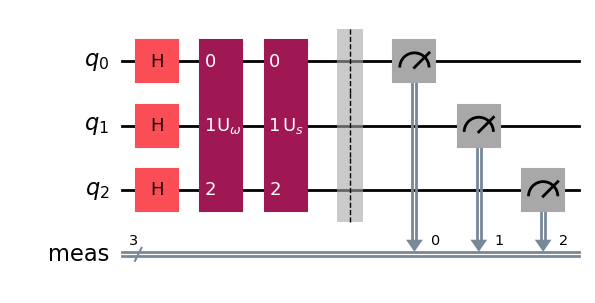

In [16]:
n = 3
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2])
grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(n), [0,1,2])
grover_circuit.measure_all()
grover_circuit.draw('mpl')

### 3.1.1 Experiment with Simulators  <a id='3qubits-simulation'></a>

We can run the above circuit on the simulator. 

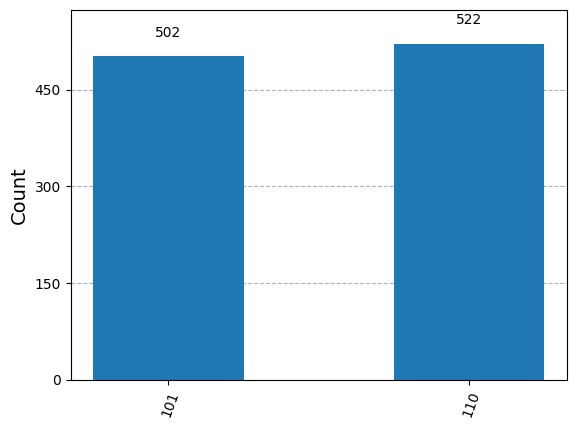

In [17]:
aer_sim = AerSimulator()
transpiled_grover_circuit = transpile(grover_circuit, aer_sim)
results = aer_sim.run(transpiled_grover_circuit).result()
counts = results.get_counts()
plot_histogram(counts)


As we can see, the algorithm discovers our marked states $\lvert101\rangle$ and $\lvert110\rangle$.

### 3.1.2 Experiment with Real Devices  <a id='3qubits-device'></a>

We can run the circuit on the real device as below.

In [ ]:
# Run it and get the result

As we can (hopefully) see, there is a higher chance of measuring $\lvert101\rangle$ and $\lvert110\rangle$. The other results are due to errors in the quantum computation. 

## 4. Solving Sudoku using Grover's Algorithm <a id="sudoku"></a>

The oracles used throughout this chapter so far have been created with prior knowledge of their solutions. We will now solve a simple problem using Grover's algorithm, for which we do not necessarily know the solution beforehand. Our problem is a 2×2 binary sudoku, which in our case has two simple rules:

- No column may contain the same value twice
- No row may contain the same value twice

If we assign each square in our sudoku to a variable like so:

![2×2 binary sudoku, with each square allocated to a different variable](images/binary_sudoku.png)

we want our circuit to output a solution to this sudoku.

Note that, while this approach of using Grover's algorithm to solve this problem is not practical (you can probably find the solution in your head!), the purpose of this example is to demonstrate the conversion of classical [decision problems](https://en.wikipedia.org/wiki/Decision_problem) into oracles for Grover's algorithm.

### 5.1 Turning the Problem into a Circuit

We want to create an oracle that will help us solve this problem, and we will start by creating a circuit that identifies a correct solution.  We simply need to create a _classical_ function on a quantum circuit that checks whether the state of our variable bits is a valid solution.

Since we need to check down both columns and across both rows, there are 4 conditions we need to check:

```
v0 ≠ v1   # check along top row
v2 ≠ v3   # check along bottom row
v0 ≠ v2   # check down left column
v1 ≠ v3   # check down right column
```

Remember we are comparing classical (computational basis) states. For convenience, we can compile this set of comparisons into a list of clauses:

In [18]:
clause_list = [[0,1],
               [0,2],
               [1,3],
               [2,3]]

We will assign the value of each variable to a bit in our circuit. To check these clauses computationally, we will use the `XOR` gate.

In [19]:
def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

Convince yourself that the `output0` bit in the circuit below will only be flipped if `input0 ≠ input1`:

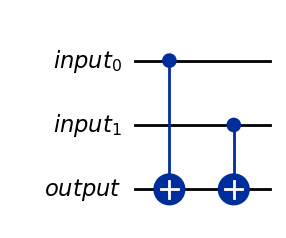

In [20]:
# We will use separate registers to name the bits
in_qubits = QuantumRegister(2, name='input')
out_qubit = QuantumRegister(1, name='output')
qc = QuantumCircuit(in_qubits, out_qubit)
XOR(qc, in_qubits[0], in_qubits[1], out_qubit)
qc.draw('mpl')

This circuit checks whether `input0 == input1` and stores the output to `output0`. To check each clause, we repeat this circuit for each pairing in `clause_list` and store the output to a new bit:

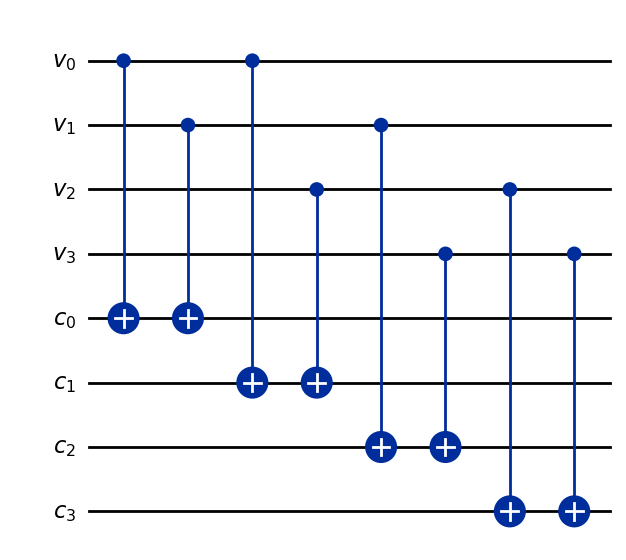

In [21]:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')  # variable bits
clause_qubits = QuantumRegister(4, name='c')  # bits to store clause-checks

# Create quantum circuit
qc = QuantumCircuit(var_qubits, clause_qubits)

# Use XOR gate to check each clause
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

qc.draw('mpl')

The final state of the bits `c0, c1, c2, c3` will only all be `1` in the case that the assignments of `v0, v1, v2, v3` are a solution to the sudoku. To complete our checking circuit, we want a single bit to be `1` if (and only if) all the clauses are satisfied, this way we can look at just one bit to see if our assignment is a solution. We can do this using a multi-controlled-Toffoli-gate:

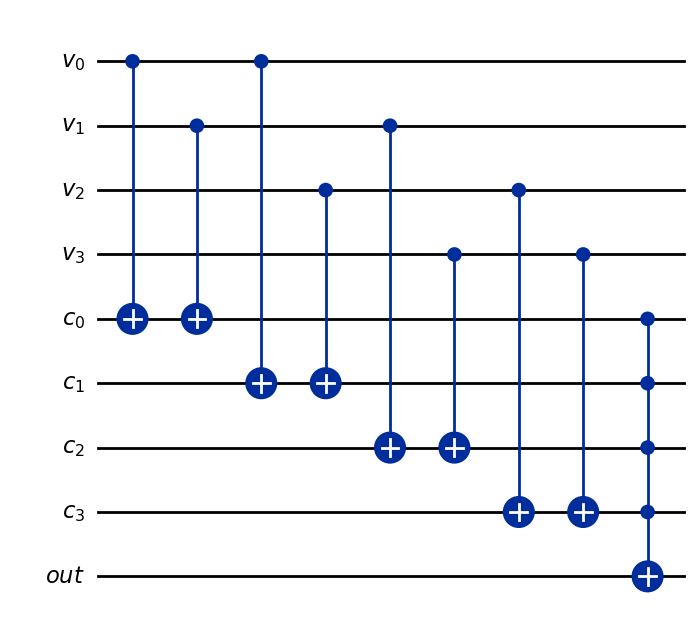

In [22]:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit)

# Compute clauses
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

# Flip 'output' bit if all clauses are satisfied
qc.mcx(clause_qubits, output_qubit)

qc.draw('mpl')

The circuit above takes as input an initial assignment of the bits `v0`, `v1`, `v2` and `v3`, and all other bits should be initialized to `0`. After running the circuit, the state of the `out0` bit tells us if this assignment is a solution or not; `out0 = 0` means the assignment _is not_ a solution, and `out0 = 1` means the assignment _is_ a solution.

**Important:** Before you continue, it is important you fully understand this circuit and are convinced it works as stated in the paragraph above.

### 5.2 Uncomputing, and Completing the Oracle

We can now turn this checking circuit into a Grover oracle using. To recap, we have 3 registers: 
- One register which stores our sudoku variables (we'll say $x = v_3, v_2, v_1, v_0$)
- One register that stores our clauses (this starts in the state $|0000\rangle$ which we'll abbreviate to $|0\rangle$)
- And one qubit ($|\text{out}_0\rangle$) that we've been using to store the output of our checking circuit. 

To create an oracle, we need our circuit ($U_\omega$) to perform the transformation:

$$
U_\omega|x\rangle|0\rangle|\text{out}_0\rangle = |x\rangle|0\rangle|\text{out}_0\oplus f(x)\rangle
$$

If we set the `out0` qubit to the superposition state $|{-}\rangle$ we have:

$$
\begin{aligned}
U_\omega|x\rangle|0\rangle|{-}\rangle 
&= U_\omega|x\rangle|0\rangle\otimes\tfrac{1}{\sqrt{2}}(|0\rangle - |1\rangle)\\
&= |x\rangle|0\rangle\otimes\tfrac{1}{\sqrt{2}}(|0\oplus f(x)\rangle - |1\oplus f(x)\rangle)
\end{aligned}
$$

If $f(x) = 0$, then we have the state:

$$
\begin{aligned}
&= |x\rangle|0\rangle\otimes \tfrac{1}{\sqrt{2}}(|0\rangle - |1\rangle)\\
&= |x\rangle|0\rangle|-\rangle\\
\end{aligned}
$$


(i.e. no change). But if $f(x) = 1$ (i.e. $x = \omega$), we introduce a negative phase to the $|{-}\rangle$ qubit:

$$
\begin{aligned}
&= \phantom{-}|x\rangle|0\rangle\otimes\tfrac{1}{\sqrt{2}}(|1\rangle - |0\rangle)\\
&= \phantom{-}|x\rangle|0\rangle\otimes -\tfrac{1}{\sqrt{2}}(|0\rangle - |1\rangle)\\
&= -|x\rangle|0\rangle|-\rangle\\
\end{aligned}
$$

This is a functioning oracle that uses two auxiliary registers in the state $|0\rangle|{-}\rangle$:

$$
U_\omega|x\rangle|0\rangle|{-}\rangle = \Bigg\{
\begin{aligned}
\phantom{-}|x\rangle|0\rangle|-\rangle \quad \text{for} \; x \neq \omega \\
-|x\rangle|0\rangle|-\rangle \quad \text{for} \; x = \omega \\
\end{aligned}
$$

To adapt our checking circuit into a Grover oracle, we need to guarantee the bits in the second register (`c`) are always returned to the state $|0000\rangle$ after the computation. To do this, we simply repeat the part of the circuit that computes the clauses which guarantees `c0 = c1 = c2 = c3 = 0` after our circuit has run. We call this step _'uncomputation'_.

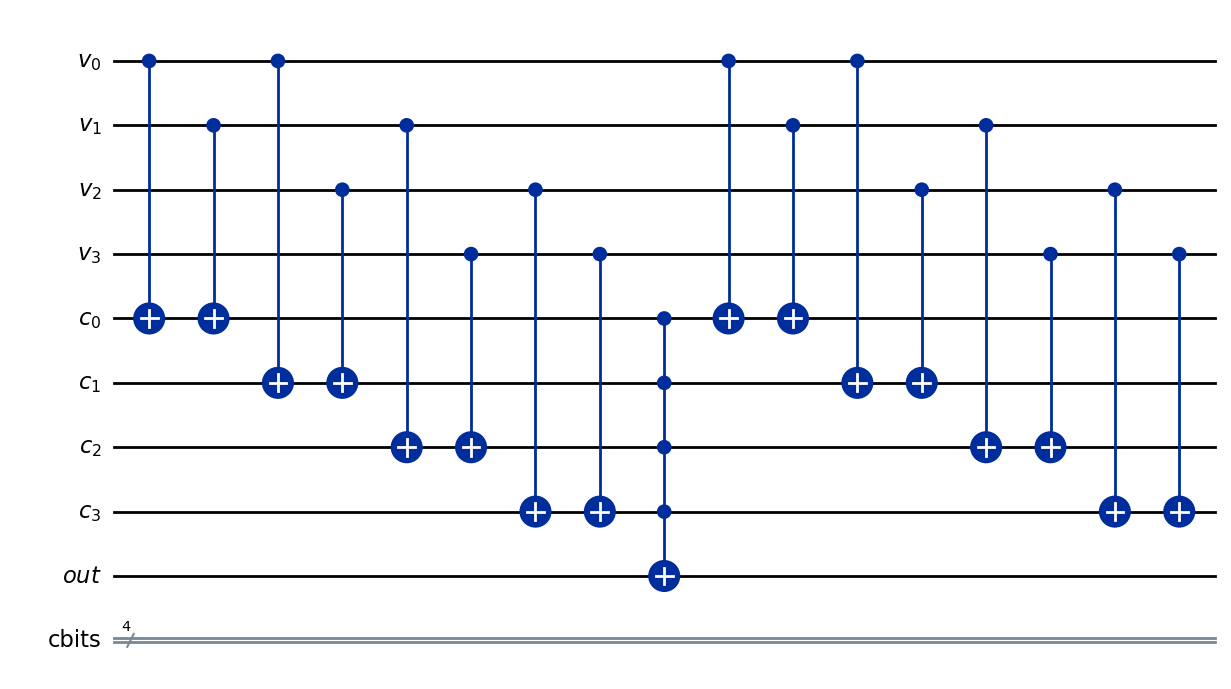

In [23]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

def sudoku_oracle(qc, clause_list, clause_qubits):
    # Compute clauses
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    qc.mcx(clause_qubits, output_qubit)

    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

sudoku_oracle(qc, clause_list, clause_qubits)
qc.draw('mpl')

In summary, the circuit above performs:

$$
U_\omega|x\rangle|0\rangle|\text{out}_0\rangle = \Bigg\{
\begin{aligned}
|x\rangle|0\rangle|\text{out}_0\rangle \quad \text{for} \; x \neq \omega \\
|x\rangle|0\rangle\otimes X|\text{out}_0\rangle \quad \text{for} \; x = \omega \\
\end{aligned}
$$

and if the initial state of $|\text{out}_0\rangle = |{-}\rangle$,:

$$
U_\omega|x\rangle|0\rangle|{-}\rangle = \Bigg\{
\begin{aligned}
\phantom{-}|x\rangle|0\rangle|-\rangle \quad \text{for} \; x \neq \omega \\
-|x\rangle|0\rangle|-\rangle \quad \text{for} \; x = \omega \\
\end{aligned}
$$

### 5.3 The Full Algorithm

All that's left to do now is to put this oracle into Grover's algorithm!

In [24]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialize 'out0' in state |->
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
for i in range(4)


qc.barrier()  # for visual separation

## First Iteration
# Apply our oracle


qc.barrier()  # for visual separation
# Apply our diffuser


## Second Iteration


qc.barrier()  # for visual separation
# Apply our diffuser


# Measure the variable qubits
qc.measure(var_qubits, cbits)

qc.draw(fold=-1, output='mpl')

SyntaxError: expected ':' (3647240638.py, line 11)

In [25]:
# Simulate and plot results

## 6. References <a id='references'></a>

1. L. K. Grover (1996), "A fast quantum mechanical algorithm for database search", Proceedings of the 28th Annual ACM Symposium on the Theory of Computing (STOC 1996), [doi:10.1145/237814.237866](http://doi.acm.org/10.1145/237814.237866), [arXiv:quant-ph/9605043](https://arxiv.org/abs/quant-ph/9605043)
2. C. Figgatt, D. Maslov, K. A. Landsman, N. M. Linke, S. Debnath & C. Monroe (2017), "Complete 3-Qubit Grover search on a programmable quantum computer", Nature Communications, Vol 8, Art 1918, [doi:10.1038/s41467-017-01904-7](https://doi.org/10.1038/s41467-017-01904-7), [arXiv:1703.10535 ](https://arxiv.org/abs/1703.10535)
3. I. Chuang & M. Nielsen, "Quantum Computation and Quantum Information", Cambridge: Cambridge University Press, 2000.